# Experiment 8

In [1]:
from copy import deepcopy
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, shapiro, ttest_ind
from sklearn.decomposition import PCA

from population.population import Population
from utils.dictionary import *
from utils.myutils import load_dict

In [2]:
# Hyperparameters
use_backup = True
# populations = ['default', 'biased', 'gru_nr']
# populations = ['default', 'gru_nr']
populations = ['default', 'biased']
max_v = 30
max_g = 100
hops = 10

In [3]:
# Parameters
FOLDER = f"population{'_backup' if use_backup else ''}/storage/experiment8/"
COLORS = [sns.color_palette()[i] for i in range(10)]
TITLES = {
    'default': 'NEAT-GRU',
    'biased': 'BIASED',
    'gru_nr': 'NEAT-GRU-NR',
}

## Final result

### Fetch

In [4]:
# The dataframe which only concerns the last generation
df_sol = pd.DataFrame()
for p in populations:
    results = []
    for v in range(1, max_v+1):
        temp = load_dict(f'{FOLDER}{p}/v{v}/evaluation/{max_g:05d}/results')
        results.append(max([t['Fitness'] for t in temp.values()]))
    df_sol[p] = results

### Analyse

,default,biased
0,4.433534,3.759852
1,3.941045,4.547839
2,4.273178,4.733581
3,4.202701,4.833064
4,4.690362,4.247697
5,4.128300,4.609283
6,4.045464,4.668146
7,4.197117,5.015152
8,4.566661,4.629198
9,4.823381,4.027082


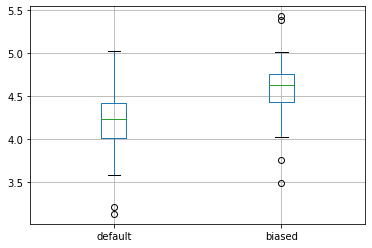

In [5]:
df_sol.boxplot()
df_sol

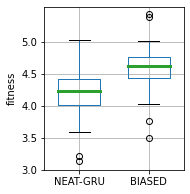

In [6]:
plt.figure(figsize=(2.5,3))
df_sol.boxplot(medianprops={'linewidth':3}, widths=(0.6, 0.6))
plt.ylabel('fitness')
plt.yticks([round(3+i/2,1) for i in range(5)])
plt.xticks([i for i in range(1,3)], ['NEAT-GRU', 'BIASED'])
plt.savefig("delete_me/temp_boxplot.png", bbox_inches='tight', pad_inches=0.02, dpi=500)
plt.savefig("delete_me/temp_boxplot.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

###  Statistics

Compare the final results (the fitness at gen100) of the data.

In [7]:
# Do not consider the outliers
Q1 = df_sol.quantile(0.25)
Q3 = df_sol.quantile(0.75)
IQR = Q3 - Q1
df_sol = df_sol[(df_sol >= (Q1 - 1.5 * IQR)) & (df_sol <= (Q3 + 1.5 * IQR))]
IQR

default    0.404229
biased     0.321862
dtype: float64

In [8]:
# Example of the Shapiro-Wilk Normality Test
for pop in populations:
    stat, p = shapiro(df_sol[pop].dropna())
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(f'{pop} is probably Gaussian (p={p:.5f})')
    else:
        print(f'{pop} is probably not Gaussian (p={p:.5f})')

stat=0.986, p=0.965
default is probably Gaussian (p=0.96455)
stat=0.957, p=0.333
biased is probably Gaussian (p=0.33331)


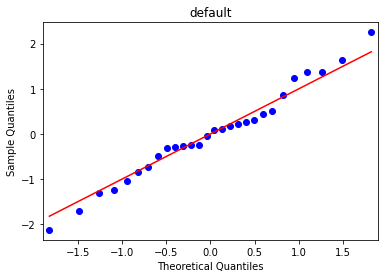

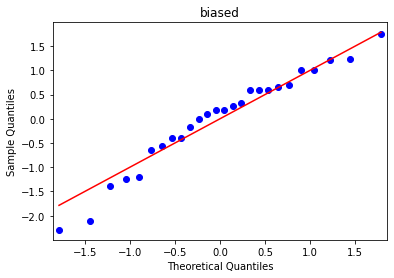

In [9]:
for p in populations:
    sm.qqplot(df_sol[p].dropna(), line ='s', fit=True) 
    plt.title(p)
    plt.show() 

In [10]:
for i in range(len(populations)):
    pop1 = populations[i]
    for j in range(i+1, len(populations)):
        pop2 = populations[j]
        stat, p = mannwhitneyu(df_sol[pop1].dropna(), 
                               df_sol[pop2].dropna(), 
                               use_continuity=False, 
                               alternative='two-sided')
        print(f'{pop1} vs {pop2} -  p={p} - {"significant" if p < .05 else "insignificant"}')

default vs biased -  p=0.0007836679598086043 - significant


In [11]:
for i in range(len(populations)):
    pop1 = populations[i]
    for j in range(i+1, len(populations)):
        pop2 = populations[j]
        stat, p = ttest_ind(df_sol[pop1].dropna(), 
                            df_sol[pop2].dropna())
        print(f'{pop1} vs {pop2} -  p={p} - {"significant" if p < .05 else "insignificant"}')

default vs biased -  p=0.0004890754003067441 - significant


## Data throughout its lifetime

### Fetch

In [12]:
# 'default' population
data = []
for v in range(1, max_v+1):
    row = []
    for g in range(0,max_g+1,hops):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}default/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FITNESS] for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_default = pd.DataFrame(data).transpose()  # Rows indicate generations
df_default.columns = [v for v in range(1, max_v+1)]
df_default

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.126805,0.101633,0.050000,0.233934,0.327431,0.339325,0.328967,0.024798,0.150672,0.036195,...,0.177431,0.076589,0.274061,0.133763,0.067068,0.193684,0.297609,0.207275,0.069902,0.228359
1,1.989438,2.127396,1.310473,3.125223,0.909649,1.360482,3.211603,1.706146,2.567259,3.638776,...,0.882742,1.706798,2.642011,1.817979,1.874606,1.723449,2.416587,1.618331,2.199212,2.038805
2,2.961487,2.534089,1.976462,3.139509,1.276539,2.572645,3.092016,2.443143,2.989573,4.775277,...,1.842822,3.383173,3.651890,3.066244,3.153999,2.725632,2.967159,2.560004,3.763708,3.841512
3,3.441146,2.424617,2.714817,3.598022,1.665802,3.210748,3.239986,2.795792,3.208624,4.775277,...,2.908500,3.572875,3.868428,3.317505,3.449682,3.147576,3.137299,2.926190,4.217827,4.106410
4,3.990679,2.639615,3.089644,3.635355,1.996252,3.156435,3.361441,3.895206,4.148091,4.763007,...,3.625303,3.815851,3.964599,3.389667,3.609956,3.147576,3.159310,3.206322,4.217827,4.118630
5,4.106995,2.769737,3.263029,4.050302,2.147238,3.667577,3.724040,3.858519,4.606316,4.763007,...,4.172205,4.120605,4.196758,3.791838,3.659898,3.333232,3.185493,3.233318,4.253082,4.253365
6,4.162789,3.082459,3.449377,3.891735,2.306245,3.677926,3.783568,4.227342,4.668751,4.723657,...,4.226038,4.120644,4.188411,3.965832,4.262881,3.330664,3.244084,3.333827,4.253082,4.295890
7,4.278171,3.252926,3.626462,4.180924,3.098313,3.622870,3.987695,4.256615,4.668751,4.711361,...,4.367625,4.201678,4.396356,4.150417,4.339924,3.217996,3.398359,3.613967,4.406726,4.108170
8,4.357510,3.252674,3.683472,4.180924,3.153837,3.736347,4.120402,4.237638,4.682665,4.705055,...,4.453445,4.098451,4.360764,4.129152,4.339924,3.544088,3.549260,4.084654,4.623388,3.962428
9,4.345988,3.623530,4.054629,4.197221,4.606053,4.025181,4.163817,4.220711,4.682122,4.860543,...,4.587743,4.317112,4.370704,4.297323,4.358415,3.754612,3.525316,4.242246,5.027099,4.098954


In [13]:
# 'gru_nr' population
data = []
for v in range(1, max_v+1):
    row = []
    for g in range(0,max_g+1,hops):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}gru_nr/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FITNESS] for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_gru_nr = pd.DataFrame(data).transpose()  # Rows indicate generations
df_gru_nr.columns = [v for v in range(1, max_v+1)]
df_gru_nr

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.156048,0.080691,0.069907,0.138917,0.053134,0.153652,0.178346,0.061173,0.136151,0.217417,...,0.158420,0.187629,0.179461,0.226030,0.024115,0.130385,0.024954,0.024514,0.061239,0.183872
1,2.476002,3.126799,1.069502,1.743819,0.628329,1.027974,2.439807,3.376216,1.766950,2.021245,...,1.803602,3.047463,1.948476,2.364693,2.734676,1.002972,3.138642,1.292238,2.179443,2.577080
2,3.137368,3.676572,3.011294,3.441800,1.310980,1.359591,3.761198,3.853109,3.293189,2.189106,...,2.908970,3.565233,2.915454,2.689415,3.177113,3.368175,3.193004,2.680134,2.353373,3.099926
3,3.150766,3.751116,3.413886,3.635455,1.744564,1.512387,4.192663,4.077763,3.364808,3.240291,...,3.072776,3.746148,4.005686,3.559450,3.391891,3.501265,3.429637,3.046553,3.681894,3.105308
4,3.201373,3.986651,3.578233,3.800397,2.476164,2.281302,4.307949,4.077763,3.381364,3.396658,...,3.330538,4.008615,4.321141,4.222100,3.410010,3.647525,3.520989,2.870671,4.032315,3.222551
5,3.594190,4.135158,3.763934,3.731302,2.658765,2.749509,4.388189,3.911971,3.908636,3.395785,...,3.467426,4.005947,4.314480,4.331093,3.688292,3.757952,3.683453,2.934464,4.246455,3.294395
6,3.310188,4.135716,3.523174,3.747646,2.990278,3.448622,4.382606,3.922173,3.953072,3.379673,...,3.672620,4.096034,4.442276,4.331093,3.759900,3.957532,3.583483,3.159205,4.287527,3.051837
7,3.576015,4.206963,3.733330,3.703552,3.287396,3.783671,4.382606,3.922417,4.003380,3.427020,...,3.954723,4.357104,4.465127,4.354889,3.864615,3.932160,3.944563,3.201077,4.338000,3.318984
8,3.628713,4.213775,3.823057,3.553979,3.676105,3.783671,4.247758,4.004709,4.051243,3.486915,...,4.222928,4.360977,4.360001,4.164980,3.873307,4.151871,3.955310,3.414850,4.308147,3.248747
9,3.668481,4.128112,3.758078,3.648109,3.772470,3.707399,4.238658,4.045259,4.098325,3.596846,...,4.423864,4.338070,4.561890,4.215552,4.024527,4.208542,4.225947,3.741254,4.494074,3.463231


In [14]:
# 'biased' population
data = []
for v in range(1, max_v+1):
    row = []
    for g in range(0,max_g+1,hops):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}biased/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FITNESS] for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_biased = pd.DataFrame(data).transpose()  # Rows indicate generations
df_biased.columns = [v for v in range(1, max_v+1)]
df_biased

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.115264,0.215772,0.050018,0.174669,0.095919,0.135221,0.243556,0.118306,0.124377,0.105093,...,0.042237,0.179380,0.270821,0.217791,0.048462,0.192170,0.245334,0.610784,0.172314,0.024115
1,1.046696,3.676311,2.146224,2.269551,2.113905,2.114707,2.621355,1.729156,3.633864,1.752015,...,1.695648,0.654125,3.500848,2.114138,3.331517,1.240560,3.197277,0.777648,3.793369,2.901407
2,1.777647,3.714755,3.008915,3.477012,2.908226,3.322373,3.058498,2.618778,4.332502,2.431926,...,3.311496,1.921058,4.130446,2.833432,3.866569,3.680862,4.462375,2.071019,3.798973,3.521779
3,2.545361,4.091895,3.361248,3.826317,3.546776,4.064863,4.080600,3.274158,4.596982,2.920237,...,3.396544,3.181549,4.313658,3.727081,4.076207,3.818209,4.765190,2.841428,4.089695,3.779437
4,2.783155,4.088330,3.563896,3.872672,3.851611,4.176898,4.321965,3.885388,4.586705,3.006257,...,3.558225,3.895376,4.041809,3.820661,4.300999,3.743467,4.639857,3.084288,4.167292,3.771030
5,3.202661,4.149387,3.661168,3.895410,3.862550,4.382228,4.488198,4.046991,4.627837,3.427169,...,4.036633,3.901380,4.210385,4.260759,4.511173,3.928054,4.357225,3.346917,4.302208,4.037544
6,3.264155,4.387390,4.030953,4.405818,4.053993,4.452497,4.462647,4.691389,4.684200,3.438703,...,4.221724,3.900008,4.377848,4.298856,4.586302,3.755521,4.839274,4.199553,4.302208,4.294657
7,3.681930,4.490074,4.109378,4.384869,4.182746,4.507601,4.509110,5.063955,4.666387,3.738883,...,4.302450,3.917772,4.377646,4.541406,4.754683,4.100779,4.388978,4.176465,4.409489,4.409690
8,3.636116,4.500831,4.153034,4.600638,4.277730,4.578865,4.544028,5.046209,4.667625,3.884609,...,4.222818,3.933827,4.716496,4.568725,4.881343,4.161530,4.826509,4.354012,4.506054,4.533084
9,3.592435,4.547839,4.441216,4.555059,4.265624,4.624152,4.669095,4.989994,4.678259,4.025693,...,4.264852,4.058572,5.332158,4.556062,4.832375,4.260963,4.826864,4.629492,4.651342,4.479308


### Plot

In [15]:
def plot_performance(plot_default, plot_biased, plot_gru_nr):
    plt.figure(figsize=(4, 2.5))
    max_fitness = 0


    ### DEFAULT ###
    if plot_default:
        c = 1
        # Get quantiles
        q1 = df_default.quantile(0.25, axis=1).values
        q2 = df_default.quantile(0.50, axis=1).values
        q3 = df_default.quantile(0.75, axis=1).values

        # Plot
        plt.plot([i for i in range(len(q1))], 
                 q1, 
                 color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q3))], 
                 q3, color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q2))], 
                 q2, 
                 color=COLORS[c], 
                 linestyle="-", 
                 linewidth=2, 
                 label=TITLES['default'])
        plt.fill_between([i for i in range(len(q1))],
                         q1, 
                         q3,
                         color=COLORS[c], 
                         alpha=0.1)
        max_fitness = max(q3.max(), max_fitness)


    ### BIASED ###
    if plot_biased:
        c = 0
        # Get quantiles
        q1 = df_biased.quantile(0.25, axis=1).values
        q2 = df_biased.quantile(0.50, axis=1).values
        q3 = df_biased.quantile(0.75, axis=1).values

        # Plot
        plt.plot([i for i in range(len(q1))], 
                 q1, 
                 color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q3))], 
                 q3, color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q2))], 
                 q2, 
                 color=COLORS[c], 
                 linestyle="-", 
                 linewidth=2, 
                 label=TITLES['biased'])
        plt.fill_between([i for i in range(len(q1))],
                         q1, 
                         q3,
                         color=COLORS[c], 
                         alpha=0.1)
        max_fitness = max(q3.max(), max_fitness)


    ### GRU-NR ###
    if plot_gru_nr:
        c = 2
        # Get quantiles
        q1 = df_gru_nr.quantile(0.25, axis=1).values
        q2 = df_gru_nr.quantile(0.50, axis=1).values
        q3 = df_gru_nr.quantile(0.75, axis=1).values

        # Plot
        plt.plot([i for i in range(len(q1))], 
                 q1, 
                 color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q3))], 
                 q3, color=COLORS[c], 
                 linestyle=":", 
                 linewidth=.5)
        plt.plot([i for i in range(len(q2))], 
                 q2, 
                 color=COLORS[c], 
                 linestyle="-", 
                 linewidth=2, 
                 label=TITLES['gru_nr'])
        plt.fill_between([i for i in range(len(q1))],
                         q1, 
                         q3,
                         color=COLORS[c], 
                         alpha=0.1)
        max_fitness = max(q3.max(), max_fitness)


    # Show the figure
    leg = plt.legend(loc='upper center',
                     bbox_to_anchor=(0.5, 1.25),
                     fancybox=True,
                     fontsize=10,
                     ncol=len(populations))
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    plt.xlabel("generation")
    plt.xticks([i for i in range(11)], [i*10 for i in range(11)])
    plt.xlim(0,10)
    plt.ylabel('fitness')
    plt.yticks([i for i in range(int(max_fitness)+2)])
    plt.ylim(0,int(max_fitness)+1)
    plt.grid()
    plt.tight_layout()
    name = "experiment8"
    if plot_default: name += "_default"
    if plot_biased: name += "_biased"
    if plot_gru_nr: name += "_gru_nr"
    plt.savefig(f"delete_me/{name}.png", bbox_inches='tight', pad_inches=0.02, dpi=500)
    plt.show()
    plt.close()

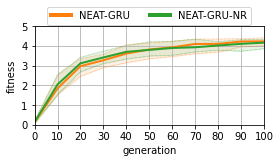

In [16]:
plot_performance(plot_default=True, plot_biased=False, plot_gru_nr=True)

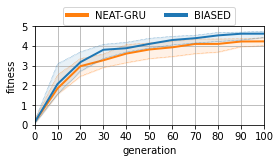

In [17]:
plot_performance(True, True, False)

## Genome space of 'default'

### Fetch

In [18]:
# More populations to compare with
max_v = 54
min_fit = 3.5

In [19]:
genomes = []
for v in range(1, max_v+1):
    pop = Population(
        name=f'default/v{v}',
        folder_name='experiment8',
        log_print=False,
        use_backup=True,
    )
    for gen in range(3*hops,max_g+1,hops):
        pop.load(gen)
        for g in pop.population.values():  # Go over all the current genomes
            if g.fitness and g.fitness > min_fit: genomes.append(deepcopy(g))
        for i in range(1, 6):  # Add the elites of the past five generations
            g = pop.best_genome_hist[gen - i][1]
            if g.fitness > min_fit: genomes.append(deepcopy(g))

### Parse

In [20]:
def get_param(g):
    result = [v for v in g.nodes[2].bias_h]  # GRU biases
    result += [v[0] for v in g.nodes[2].weight_xh_full]  # GRU input->output
    result += [v[0] for v in g.nodes[2].weight_hh]  # GRU hidden->hidden
    result += [g.nodes[1].bias]
    result += [g.connections[(-1, 2)].weight, g.connections[(2, 1)].weight, g.connections[(-1, 1)].weight]
    return result

In [21]:
params = []
for g in genomes:
    params.append(get_param(g))

In [22]:
head = [
    'bias_r', 'bias_z', 'bias_h',
    'weight_xr', 'weight_xz', 'weight_xh',
    'weight_hr', 'weight_hz', 'weight_hh',
    'bias_rw', 'c1', 'c2', 'c0',    
]

In [23]:
df_g = pd.DataFrame(params, columns=head)

In [24]:
df_g = df_g.drop_duplicates()
print(f"Final size: {len(df_g)}")

Final size: 1643


### Visualise

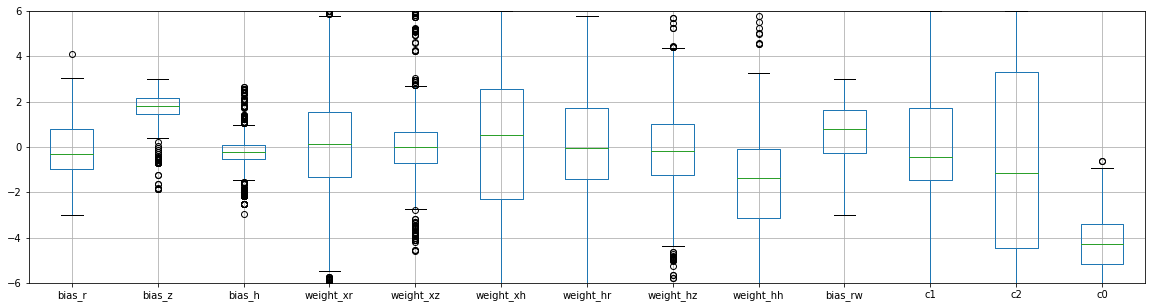

In [25]:
plt.figure(figsize=(20, 5))
df_g.boxplot()
plt.ylim(-6,6)
plt.show()
plt.close()

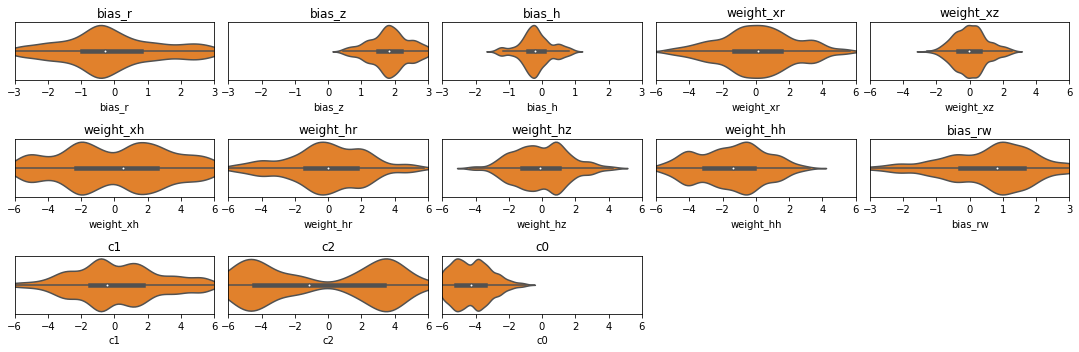

In [26]:
# Plot as a whole
plt.figure(figsize=(15,5))
for i, col in enumerate(df_g.columns):
    # Drop the outliers first
    data_temp = df_g.copy()
    q1 = data_temp[col].quantile(0.25)
    q3 = data_temp[col].quantile(0.75)
    iqr = q3 - q1
    data_temp[col] = data_temp[col][((q1 - 1.5 * iqr) < data_temp[col]) & (data_temp[col] < (q3 + 1.5 * iqr))]
    
    # Plot
    plt.subplot(int(len(data_temp.columns)/5+1),5,i+1)
    sns.violinplot(data_temp[col], color=COLORS[1])
    plt.title(col)
    if 'bias' in col:
        plt.xlim(-3,3)
    else:
        plt.xlim(-6,6)
    plt.yticks([])
plt.tight_layout()
plt.show()
plt.close()

In [27]:
# Plot separate and save
def violin_creator(h, t=None, height:float=.6):
    plt.figure(figsize=(3.25,height))

    # Format data
    data_temp = df_g.copy()

    # Drop the outliers first
    q1 = data_temp[h].quantile(0.25)
    q3 = data_temp[h].quantile(0.75)
    iqr = q3 - q1
    data_temp[h] = data_temp[h][((q1 - 1.5 * iqr) < data_temp[h]) & (data_temp[h] < (q3 + 1.5 * iqr))]

    # Create the plot
    sns.violinplot(data_temp[h].dropna(), color='#ff7f0e')
    if 'bias' in h:
        plt.xlim(-3,3)
    else:
        plt.xlim(-6,6)
    if t: plt.title(t)
    plt.yticks([])
    plt.xlabel('')
    plt.savefig(f"delete_me/{h}.png", bbox_inches='tight', pad_inches=0.02, dpi=500)
    plt.savefig(f"delete_me/{h}.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
    plt.show()
    plt.close()

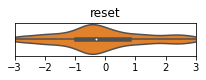

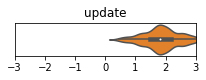

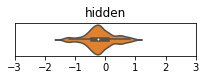

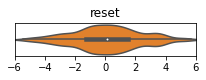

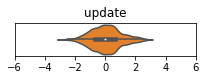

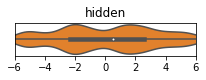

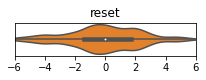

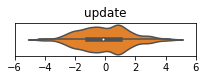

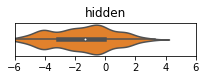

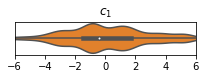

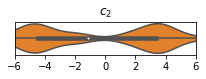

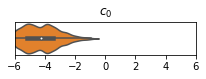

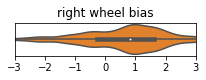

In [28]:
violin_creator('bias_r', "reset")
violin_creator('bias_z', "update")
violin_creator('bias_h', "hidden")

violin_creator('weight_xr', "reset")
violin_creator('weight_xz', "update")
violin_creator('weight_xh', "hidden")

violin_creator('weight_hr', "reset")
violin_creator('weight_hz', "update")
violin_creator('weight_hh', "hidden")

violin_creator('c1', "$c_1$")
violin_creator('c2', "$c_2$")
violin_creator('c0', "$c_0$")
violin_creator('bias_rw', "right wheel bias")

In [29]:
COLORS = ['#ffffff', sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3]]

def compare(h, t):
    plt.figure(figsize=(3,2.5))
    gs1 = gridspec.GridSpec(5,1)
    gs1.update(wspace=0, hspace=0)
    for i in sorted([i for i in range(5)], reverse=True):
        plt.subplot(gs1[i])
        if i == 0: plt.title(t)

        # Format data
        data_temp = df_g.copy()
        
        # Drop the outliers first
        q1 = data_temp[h].quantile(0.25)
        q3 = data_temp[h].quantile(0.75)
        iqr = q3 - q1
        data_temp[h] = data_temp[h][((q1 - 1.5 * iqr) < data_temp[h]) & (data_temp[h] < (q3 + 1.5 * iqr))]
        
        if i == 1:
            indices = (data_temp['c1'] >= 0) & (data_temp['c2'] >= 0)
            data_temp = data_temp[indices.values]
        elif i == 2:
            indices = (data_temp['c1'] >= 0) & (data_temp['c2'] < 0)
            data_temp = data_temp[indices.values]
        elif i == 3:
            indices = (data_temp['c1'] < 0) & (data_temp['c2'] >= 0)
            data_temp = data_temp[indices.values]
        elif i == 4:
            indices = (data_temp['c1'] < 0) & (data_temp['c2'] < 0)
            data_temp = data_temp[indices.values]        

        # Create the plot
        sns.violinplot(data_temp[h].dropna(), color=COLORS[i])
        if 'bias' in h:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
        plt.yticks([])
        plt.xlabel('')
        if i < 4: 
            plt.gca().set_xticklabels([])
    plt.savefig(f"delete_me/comp_{h}.png", bbox_inches='tight', pad_inches=0.02, dpi=500)
    plt.savefig(f"delete_me/comp_{h}.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
    plt.show()
    plt.close()

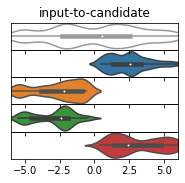

In [30]:
compare('weight_xh','input-to-candidate')

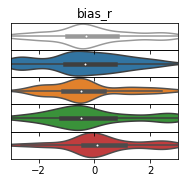

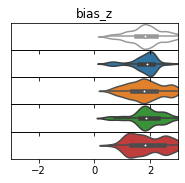

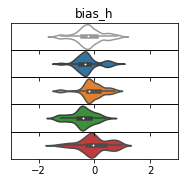

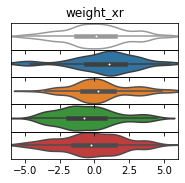

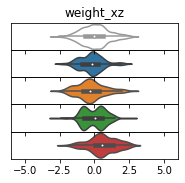

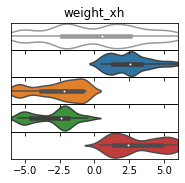

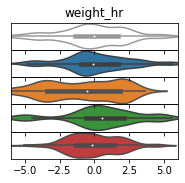

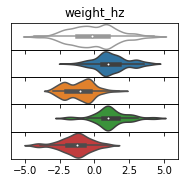

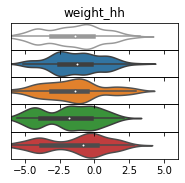

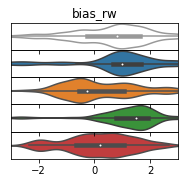

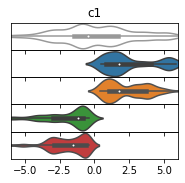

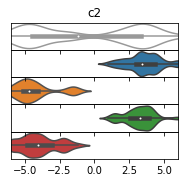

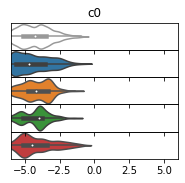

In [31]:
for h in head:
    compare(h,h)

In [32]:
def classify_connections(r):
    if r['c1'] >= 0 and r['c2'] >= 0:
        return "PP"  # Positive Positive
    elif r['c1'] >= 0 and r['c2'] < 0:
        return "PN"  # Positive Negative
    elif r['c1'] < 0 and r['c2'] >= 0:
        return "NP"  # Negative Positive
    else:
        return "NN"  # Negative Negative

In [33]:
df_g['classes'] = df_g.apply(lambda row: classify_connections(row), axis=1).values
df_g.head()

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,bias_rw,c1,c2,c0,classes
0,-0.655686,2.139471,-0.277780,1.787566,-0.728850,3.101659,-0.872249,0.580573,-3.192146,0.825515,1.448174,3.100648,-3.895533,PP
3,-0.685464,2.163037,-0.327781,1.787566,-0.575491,2.941030,-0.872249,0.578717,-3.192146,0.825515,1.562524,3.100648,-3.514895,PP
4,2.420199,2.467700,-0.926128,-0.807916,0.749830,2.346618,1.497829,-1.223468,-4.061283,-0.256585,-2.954488,-4.799525,-5.041083,NN
5,2.591266,2.435434,-0.926128,-0.521316,-0.282335,2.346618,1.497829,0.015339,-4.061283,-0.256585,-2.954488,-4.799525,-4.596333,NN
8,2.420199,2.467700,-0.926128,-0.794483,0.851053,2.346618,1.611991,-1.223468,-3.986925,-0.256585,-2.954488,-4.799525,-5.102641,NN


In [34]:
a,b = 2,75
temp = df_g.iloc[a].copy()
df_g.iloc[a] = df_g.iloc[b]
df_g.iloc[b] = temp

In [35]:
i = 0
while df_g.iloc[i]["classes"] != "NP":
    i += 1
print(i)
print(df_g.iloc[i])

2
bias_r       -0.481571
bias_z        -1.24299
bias_h       0.0709518
weight_xr     -1.36397
weight_xz     0.773489
weight_xh     -1.21522
weight_hr      1.13805
weight_hz      5.69377
weight_hh   -0.0203089
bias_rw        0.44017
c1            -2.41601
c2              2.5955
c0            -4.09624
classes             NP
Name: 4, dtype: object


### PCA

In [36]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_g[head].values)
df_g['pca-one'] = pca_result[:,0]
df_g['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.2988147  0.17083279]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


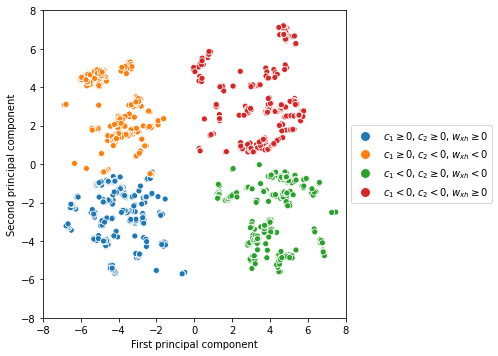

In [37]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="classes",
    palette="tab10",
    data=df_g,
)
plt.tight_layout()
legend_elements = [
    Line2D([0], [0], marker='o', color=COLORS[0], label="$c_1 \geq 0 , c_2 \geq 0 , w_{xh} \geq 0$", markerfacecolor=COLORS[1], markersize=10),
    Line2D([0], [0], marker='o', color=COLORS[0], label="$c_1 \geq 0 , c_2 < 0 , w_{xh} < 0$", markerfacecolor=COLORS[2], markersize=10),
    Line2D([0], [0], marker='o', color=COLORS[0], label="$c_1 < 0 , c_2 \geq 0 , w_{xh} < 0$", markerfacecolor=COLORS[3], markersize=10),
    Line2D([0], [0], marker='o', color=COLORS[0], label="$c_1 < 0 , c_2 < 0 , w_{xh} \geq 0$", markerfacecolor=COLORS[4], markersize=10),
]
plt.legend(handles=legend_elements,
           loc='center left',
           title=None,
           bbox_to_anchor=(1, 0.5),
           fancybox=True,
           fontsize=10,
           ncol=1)
# plt.axhline(0, linewidth=0.5, color=(0.5,0.5,0.5,0.5))
# plt.axvline(0, linewidth=0.5, color=(0.5,0.5,0.5,0.5))
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig(f"delete_me/pca.png", bbox_inches='tight', pad_inches=0.02, dpi=500)
plt.savefig(f"delete_me/pca.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()